In [1]:
import pandas as pd
import requests
import bs4
from typing import List, Dict
import numpy as np


# fbref.com

Get match urls

In [2]:
def get_team_matches(team_id, season:str)->List[Dict[str, str|bool]]:
    fbref_url = f'https://fbref.com/en/squads/{team_id}/{season}/all_comps/'
    fb_ref = requests.get(fbref_url)
    soup = bs4.BeautifulSoup(fb_ref.text)
    tables = soup.find_all("table")
    match_table = tables[5]
    match_links = [t['href'] for t in match_table.find_all("a") if '/en/matches/' in t['href']]

    matches =[]

    for idx, rw in enumerate(match_table.find_all("tr")):
        try:
            match_date = rw.find("th").text
            competition = rw.find("td",{"data-stat":"comp"}).text
            home = rw.find("td",{"data-stat":"venue"}).text =='Home'
            opponent = rw.find("td",{"data-stat":"opponent"}).text
            try:
                link = rw.find("th").find("a")['href']
            except TypeError:
                link = None
            match = {"date":match_date, "competition":competition, 
                        "is_home":home, "opponent":opponent, "link":link }
            matches.append(match)
        except AttributeError:
            continue
    return matches

Get match lineups

In [3]:
def get_match_lineups(match_id:str)->(List[str],List[str]):
    fbref_url = 'https://fbref.com/en/matches/' + match_id
    fb_ref = requests.get(fbref_url)
    soup = bs4.BeautifulSoup(fb_ref.text)
    tables = soup.find_all("table")

    df = pd.read_html(str(tables[0]))[0]
    bench_idx = df[df.iloc[:,0]=='Bench'].index[0]
    bench_lineup = df.loc[bench_idx+1:, :]
    starting_lineup = df.loc[:bench_idx-1:, :]
    starting_lineup = starting_lineup.iloc[:,1]
    bench_lineup = bench_lineup.iloc[:,1]
    return [*starting_lineup], [*bench_lineup]

In [4]:
def get_player_matches(player_id:str, season:str)->pd.DataFrame:
    """season should be in format like: '2022-2023'"""
    fbref_url = f"https://fbref.com/en/players/{player_id}/matchlogs/{season}/"
    fb_ref = requests.get(fbref_url)
    soup = bs4.BeautifulSoup(fb_ref.text)
    tables = soup.find_all("table")

    df = pd.read_html(str(tables[0]))[0]
    df= df.droplevel(0, axis=1)
    df['Min'] = df['Min'].replace("On matchday squad, but did not play", 0)
    df.dropna(axis=0, inplace=True)
    df.replace("On matchday squad, but did not play", None, inplace=True)
    keep_cols = ['Date', 'Comp', 'Squad', 'Opponent',
        'Start', 'Min']
    return df[keep_cols]


In [5]:
def get_playing_time(team_id, player_id, season):
    liverpool_matches = get_team_matches(team_id, season)
    player_matches = get_player_matches(player_id,season)
    player_games_df = pd.DataFrame(liverpool_matches).merge(player_matches, left_on='date', right_on='Date', how='left')

    # games without a link haven't been played yet (postponed or future date)
    player_games_df.dropna(subset=['link'], inplace=True)
    player_games_df.drop('Date', inplace=True, axis=1)

    return player_games_df

In [6]:
liverpool_id = '822bd0ba'
konate_id = "5ed9b537"

konate_playing_time2223 = get_playing_time(liverpool_id, konate_id, '2022-2023')
konate_playing_time2122 = get_playing_time(liverpool_id, konate_id, '2021-2022')
konate_all_liverpool_df = pd.concat([konate_playing_time2122,konate_playing_time2223])
konate_all_liverpool_df['date'] = pd.to_datetime(konate_all_liverpool_df['date'])


def get_squad_status(is_start:str):
    start_map = {"Y":"Start", "N": "Bench", np.nan:"Not in Squad"}
    return start_map[is_start]
    
konate_all_liverpool_df['Start'] = konate_all_liverpool_df['Start'].apply(get_squad_status)
konate_all_liverpool_df.fillna(0, inplace=True)

konate_all_liverpool_df.head()

,date,competition,is_home,opponent,link,Comp,Squad,Opponent,Start,Min
0,2021-08-14,Premier League,False,Norwich City,/en/matches/c52500ad/Norwich-City-Liverpool-Au...,Premier League,Liverpool,Norwich City,Bench,0
1,2021-08-21,Premier League,True,Burnley,/en/matches/94d9dac0/Liverpool-Burnley-August-...,Premier League,Liverpool,Burnley,Bench,0
2,2021-08-28,Premier League,True,Chelsea,/en/matches/78aa75e6/Liverpool-Chelsea-August-...,Premier League,Liverpool,Chelsea,Bench,0
3,2021-09-12,Premier League,False,Leeds United,/en/matches/e6a245be/Leeds-United-Liverpool-Se...,Premier League,Liverpool,Leeds United,Bench,0
4,2021-09-15,Champions Lg,True,it Milan,/en/matches/ff3e4ae2/Liverpool-Milan-September...,Champions Lg,eng Liverpool,it Milan,Bench,0


In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

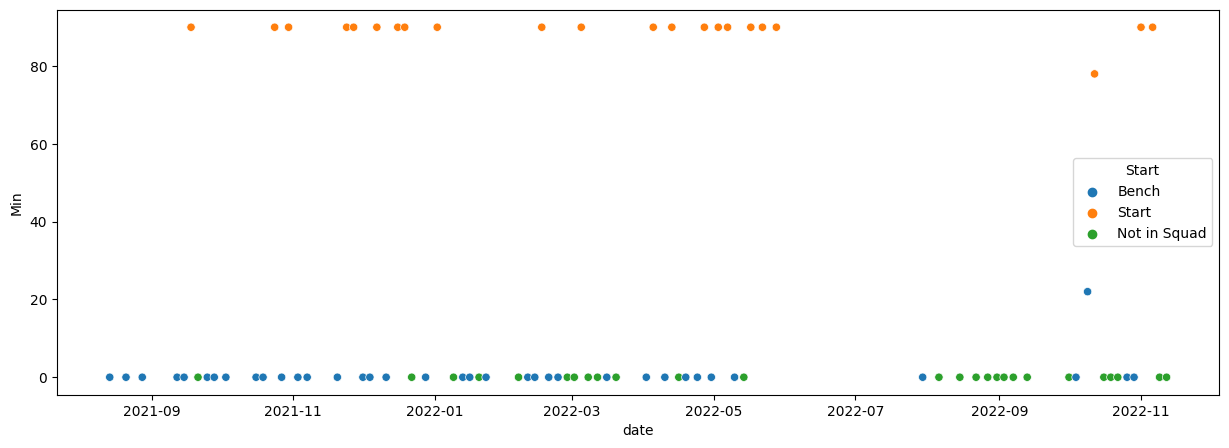

In [8]:

fig,ax = plt.subplots(figsize=(15,5))
konate_plot_data = konate_all_liverpool_df[['date', 'Min', 'Start']].set_index('date')
konate_plot_data['Min'] = pd.to_numeric(konate_plot_data['Min'])
_ = sns.scatterplot(konate_plot_data, ax=ax, x= 'date', y='Min', hue='Start')

We want to overlay injury data so we can see reasons why Konate wasn't in the squad
- this can't be found on fbref.com so we'll have to scrape another data source

transfermarkt.com has all the data we need - we could've skipped the fbref stuff above :)

![tm data](./transfrmarkt-data.png)

In [9]:
headers ={
    "sec-ch-ua": '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
}
tm_res = requests.get(url = "https://www.transfermarkt.com/ibrahima-konate/leistungsdaten/spieler/357119/saison/2022/plus/1", headers=headers)
dfs = pd.read_html(tm_res.content)
match_dfs =[]
for idx,df in enumerate(dfs):
    if 'Matchday' in df.columns:
        match_dfs.append(df)
all_matches = pd.concat(match_dfs)
all_matches = all_matches.loc[all_matches.iloc[:,0].apply(lambda x:'Squad' not in x)]
all_matches['Date'] = pd.to_datetime(all_matches['Date'])
all_matches.head()

,Matchday,Date,Home team,Home team.1,Away team,Away team.1,Result,Pos.,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Group A,2022-09-07,NaN,SSC Napoli,NaN,Liverpool,4:1,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury
1,Group A,2022-09-13,NaN,Liverpool,NaN,Ajax,2:1,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury
2,Group A,2022-10-04,NaN,Liverpool,NaN,Rangers,2:0,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench
3,Group A,2022-10-12,NaN,Rangers,NaN,Liverpool,1:7,CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79',79',NaN
4,Group A,2022-10-26,NaN,Ajax,NaN,Liverpool,0:3,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench


In [10]:
all_matches['min_played'] = all_matches.iloc[:,16]
all_matches['subbed_off'] = all_matches.iloc[:,15]
all_matches['subbed_on'] = all_matches.iloc[:,14]
all_matches.dropna(axis=1, how='all', inplace=True)
all_matches = all_matches[['Date', 'Home team.1','Away team.1', 'Result','min_played','subbed_on', 'subbed_off']]
all_matches.head()

,Date,Home team.1,Away team.1,Result,min_played,subbed_on,subbed_off
0,2022-09-07,SSC Napoli,Liverpool,4:1,Knee Injury,Knee Injury,Knee Injury
1,2022-09-13,Liverpool,Ajax,2:1,Knee Injury,Knee Injury,Knee Injury
2,2022-10-04,Liverpool,Rangers,2:0,on the bench,on the bench,on the bench
3,2022-10-12,Rangers,Liverpool,1:7,79',NaN,79'
4,2022-10-26,Ajax,Liverpool,0:3,on the bench,on the bench,on the bench


Separate out columns for minutes played and availability status - i.e. injured, on bench etc

In [11]:
def get_availability(row:pd.Series):
    if row['min_played']>0:
        if row['subbed_on'] is np.nan:
            return "Played (starter)"
        return "Played (sub)"
    if row['subbed_on'] =='on the bench':
        return "Bench"
    if row['subbed_on'] == 'Not in squad':
        return 'Not in squad'
    return "Injured"
    
def get_min_played(min_played:str):
    minutes_split = min_played.split("'")
    if len(minutes_split)<2:
        return 0
    else:
        return int(minutes_split[0])

In [12]:
all_matches['min_played'] = all_matches['min_played'].apply(get_min_played)

# create categories based on subbed on/off, minutes played
all_matches['availability'] = all_matches.apply(get_availability, axis=1)
all_matches.head()

,Date,Home team.1,Away team.1,Result,min_played,subbed_on,subbed_off,availability
0,2022-09-07,SSC Napoli,Liverpool,4:1,0,Knee Injury,Knee Injury,Injured
1,2022-09-13,Liverpool,Ajax,2:1,0,Knee Injury,Knee Injury,Injured
2,2022-10-04,Liverpool,Rangers,2:0,0,on the bench,on the bench,Bench
3,2022-10-12,Rangers,Liverpool,1:7,79,NaN,79',Played (starter)
4,2022-10-26,Ajax,Liverpool,0:3,0,on the bench,on the bench,Bench


We can now do the same plot as before

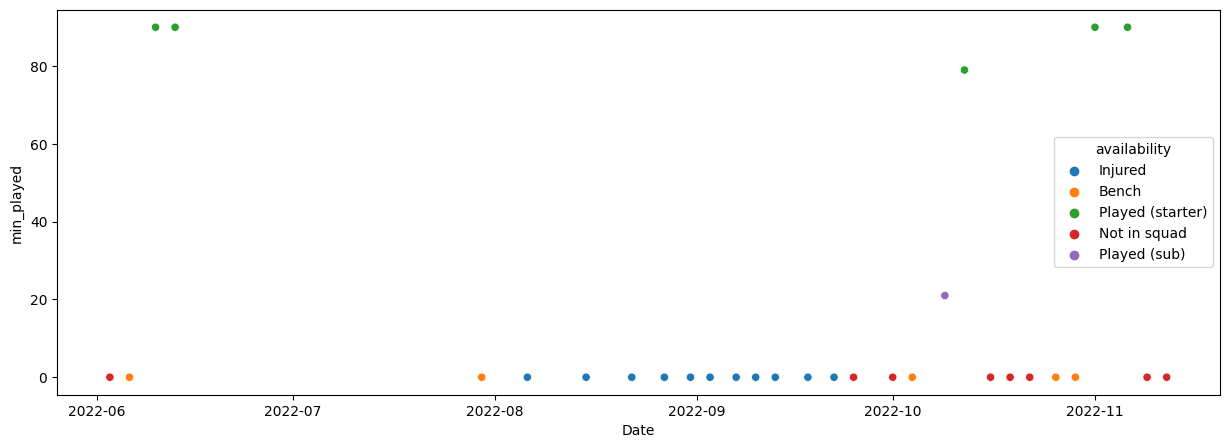

In [13]:
fig,ax = plt.subplots(figsize=(15,5))

plot = sns.scatterplot(all_matches, ax=ax, x= 'Date', y='min_played', hue='availability')

This visual doesn't capture the differences between availability levels very well - the emphasis is too much on the minutes played and there is too much white space since its rare to get intermediate values of minutes played - you either play the majority of the game or you don't. 

Let's change the availability into numeric levels and reshape the data so we can plot as a heatmap

In [14]:
availability_levels = {
                        'Injured':0, 
                        'Not in squad':1,
                        'Bench':2, 
                        'Played (sub)':3,
                        'Played (starter)':4 
                        }
all_matches['availability_level'] = all_matches['availability'].map(availability_levels)
all_matches.head()
availability_df = all_matches.loc[:,['Date','availability_level']]
availability_df.sort_values('Date', inplace=True)
availability_df['Date'] = availability_df['Date'].apply(lambda x:x.date())
availability_df = availability_df.set_index('Date').transpose()
availability_df.rename({"availability_level":"konate"},axis=0, inplace=True)

availability_df.iloc[:,0:5]

Date,2022-06-03,2022-06-06,2022-06-10,2022-06-13,2022-07-30
konate,1,2,4,4,2


This looks more like what I was thinking of - we can now add in more "rows" to the heatmaps for other players to build up a better picture of overall availability

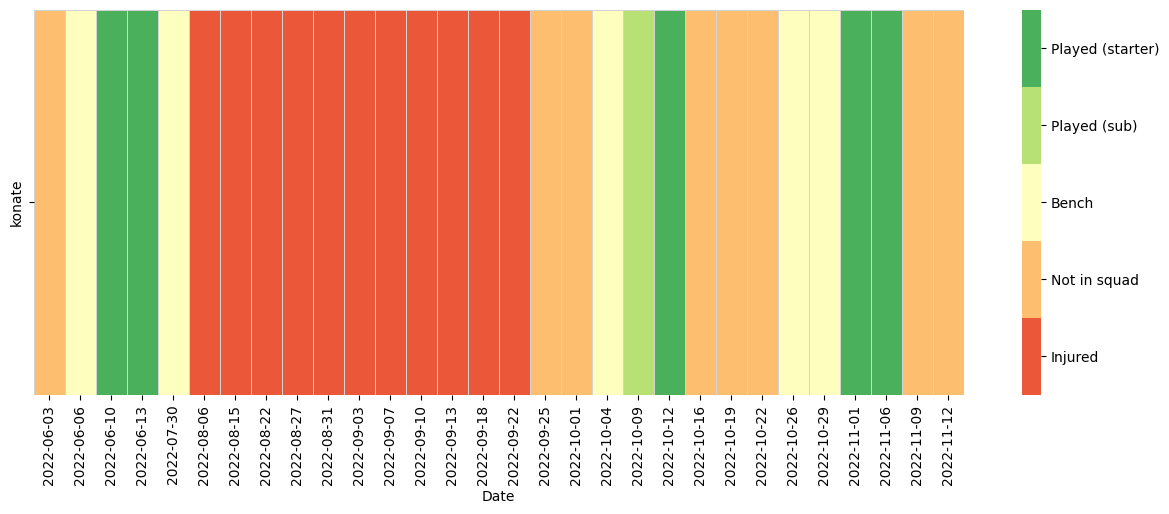

In [15]:
fig,ax = plt.subplots(figsize=(15,5))
num_levels = len(availability_levels)
plot = sns.heatmap(availability_df, ax=ax, cmap=sns.color_palette("RdYlGn",num_levels),linewidths=.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmax / num_levels * (0.5 + i) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels.keys()])


Next step: refactor steps above into functions so we can generate the data for other players, teams and time periods to make these plots in a reliable and repeatable way.